In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

pd.options.mode.chained_assignment = None

### Helper Functions

In [2]:
# row cleaners
## only to be called on df with format: city, value, city, value, ...
def row_clean_skip_1(df):
    estimate_index = list(range(1, df.shape[0], 2))
    city_index = list(range(0, df.shape[0], 2))

    df_city = df.iloc[city_index]["City"]
    df_vals = df.iloc[estimate_index].drop("City", axis= 1)
    df_vals["City"] = df_city.values
    return df_vals

## only to be called on df with format: city, blank, value, city, blank, value, ...
def row_clean_skip_2(df):
    percent_index = list(range(2, df.shape[0], 3))
    city_index = list(range(0, df.shape[0], 3))
    
    df_percent = df.iloc[percent_index].drop("City", axis= 1)
    df_city = df.iloc[city_index]["City"]
    df_percent["City"] = df_city.values
    
    return df_percent

In [3]:
# Only take the name of the city
city_types = ["city", "town", "CDP", "borough", "County", "municipality", "village", "urbana"]
city_dict = {}
# creates a dict for cleaned names and maintain index order
def clean_city_names(df):
    for i in city_types:
        city_cln = df.loc[df.City.str.contains(i)].City.apply(lambda x: re.split(i, x, flags=re.IGNORECASE)[0])
        for j in range(len(city_cln.index)):
            city_dict[city_cln.index[j]] = city_cln.values[j]
    # sort dict for index order
    sorted_city = dict(sorted(city_dict.items()))
    df.City = pd.Series(sorted_city)
    return df

In [4]:
# check for nan values in columns
def check_na(df):
    for i in df.columns:
        na_vals = df[i].loc[df[i].isna()].index.values
        print(i + str(na_vals))

### Crime Data

In [5]:
# Clean up column names
crime_cols = ["State", "City", "Population", "Violent_Crime", "Murder_Manslaughter", "Rape", "Robbery", "Aggravated_Assault", "Property_Crime", "Burglary", "Larceny_Theft", "Vehicle_Theft", "Arson"]
df_crime_city_state = pd.read_excel("data/Offenses_known_by_city_state.xls", header=3, names=crime_cols)

In [6]:
df_crime_city_state

,State,City,Population,Violent_Crime,Murder_Manslaughter,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Vehicle_Theft,Arson
0,ALABAMA3,Hoover,85670.0,114.0,4.0,15.0,27.0,68.0,1922.0,128.0,1694.0,100.0,2.0
1,ALASKA,Anchorage,287731.0,3581.0,32.0,540.0,621.0,2388.0,12261.0,1692.0,9038.0,1531.0,93.0
2,NaN,Bethel,6544.0,130.0,1.0,47.0,3.0,79.0,132.0,20.0,84.0,28.0,12.0
3,NaN,Bristol Bay Borough,852.0,2.0,0.0,0.0,0.0,2.0,20.0,5.0,8.0,7.0,0.0
4,NaN,Cordova,2150.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8108,4 The FBI determined that the agency's data we...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8109,5 Because of changes in the state/local agency...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8110,6 The FBI determined that the agency's data we...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8111,7 This agency submits rape data classified acc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# drop state column
df_crime_city = df_crime_city_state.drop("State", axis=1)

# drop footnotes for the data
footer_rows = df_crime_city[df_crime_city.City.isna()].index.values
df_crime = df_crime_city.drop(index=footer_rows)

# replace nan values in crime type columns
crime_type_cols = ["Murder_Manslaughter", "Rape", "Robbery", "Aggravated_Assault", "Burglary", "Larceny_Theft", "Vehicle_Theft", "Arson"]
for i in crime_type_cols:
    df_crime[i] = df_crime[i].fillna(0)
df_crime.Violent_Crime = df_crime[["Murder_Manslaughter", "Rape", "Robbery", "Aggravated_Assault"]].sum(axis=1)
df_crime.Property_Crime = df_crime[["Burglary", "Larceny_Theft", "Vehicle_Theft", "Arson"]].sum(axis=1)

df_crime.dtypes
# create column for total, violent, and property crime rate per 100,000
df_crime["Crime_Rate"] = ((df_crime.Violent_Crime + df_crime.Property_Crime) * 100000)/df_crime.Population
# dropping rows with no population recorded and excess columns

no_pop = df_crime.loc[df_crime.Population.isna()].index.values
df_crime_pop = df_crime.drop(no_pop)
cln_df_crime = df_crime_pop.drop(["Murder_Manslaughter", "Rape", "Robbery", "Aggravated_Assault", "Arson",
                                  "Burglary", "Larceny_Theft", "Vehicle_Theft", "Violent_Crime", "Property_Crime"], axis=1)
check_na(cln_df_crime)
cln_df_crime

City[]
Population[]
Crime_Rate[]


,City,Population,Crime_Rate
0,Hoover,85670.0,2378.895763
1,Anchorage,287731.0,5538.158905
2,Bethel,6544.0,4187.041565
3,Bristol Bay Borough,852.0,2582.159624
4,Cordova,2150.0,325.581395
...,...,...,...
8100,Sheridan,17895.0,2129.086337
8101,Thermopolis5,2830.0,1660.777385
8102,Torrington,6709.0,909.226412
8103,Wheatland,3544.0,2229.119639


### Law Enforcement Data

In [32]:
# clean up column names
law_cols = ["State", "City", "Population", "Total_Law_Enforcement", "Total_Officers", "Total_Civilians"]
df_law = pd.read_excel("data/Law_enforcement_by_city_state.xls", header=3, names=law_cols)

In [33]:
# drop state column
df_law_dropped = df_law.drop("State", axis=1)

# drop footnotes for the data
df_law_footer = df_law_dropped.drop(index=len(df_law_dropped) -1)

# remove the footer notation 
df_law_footer.City.str.replace("\d+", "", regex=True)

# replacing nan values
#check_na(df_law_footer)
df_law_footer.Population = df_law_footer.Population.fillna(0)

# find percentage of law enforcement workers to population
df_law_footer["Enforcement_Rate"] = df_law_footer.Total_Law_Enforcement / df_law_footer.Population

cln_df_law = df_law_footer.drop(["Population", "Total_Officers", "Total_Civilians"], axis=1)
check_na(cln_df_law)
cln_df_law

City[]
Total_Law_Enforcement[]
Enforcement_Rate[]


,City,Total_Law_Enforcement,Enforcement_Rate
0,Abbeville,14.0,0.005495
1,Adamsville,28.0,0.006509
2,Addison,4.0,0.005548
3,Alabaster,89.0,0.002647
4,Albertville,69.0,0.003193
...,...,...,...
8945,Sundance,3.0,0.002335
8946,Thermopolis,13.0,0.004594
8947,Torrington,25.0,0.003726
8948,Wheatland,9.0,0.002540


### Employment Rate Data

In [34]:
employ_cols = ["City", "Total_Labour_Force", "Employed", "Unemployed"]
df_employ = pd.read_csv("data/Employment_Rate.csv", names=employ_cols, header= 0)

In [35]:
# shift the variable columns up one and remove the estimate rows
df_employ_shifted = row_clean_skip_1(df_employ)

# clean City names
df_employ_city = clean_city_names(df_employ_shifted)

# nan cases
df_employ_cln = df_employ_city.dropna(axis=0, how="any")

# remove commas to convert to float
df_employ_cln = df_employ_cln.replace(to_replace={"Unemployed": "[^.0-9]", 
                                                    "Total_Labour_Force": "[^.0-9]"},
                             value= {"Unemployed": "", 
                                     "Total_Labour_Force": ""},
                             regex= True)
df_employ_cln.Unemployed = df_employ_cln.Unemployed.astype("float64")
df_employ_cln.Total_Labour_Force = df_employ_cln.Total_Labour_Force.astype("float64")



# unemployment rate
df_employ_cln["Unemployment_Rate"] = df_employ_cln["Unemployed"] / df_employ_cln["Total_Labour_Force"]
cln_unemploy_df = df_employ_cln[["City", "Unemployment_Rate"]]
check_na(cln_unemploy_df)
cln_unemploy_df

City[]
Unemployment_Rate[]


,City,Unemployment_Rate
1,Alabaster,0.054431
3,Albertville,0.010814
5,Anniston,0.045324
7,Athens,0.014845
9,Auburn,0.036191
...,...,...
4657,Mayagüez zona,0.248215
4659,Ponce zona,0.099934
4661,San Juan zona,0.178230
4663,Trujillo Alto zona,0.032412


### Median Earnings Data

In [36]:
df_earn = pd.read_csv("data/Median_Earnings.csv", names= ["City", "Median_Earnings"], header= 0)

In [37]:
# shift earnings
df_earn_shifted = row_clean_skip_1(df_earn)

# clean city names
df_earn_cln = clean_city_names(df_earn_shifted)

# nan cases
#check_na(df_earn_cln)
df_earn_cln2 = df_earn_cln.dropna(axis=0, how="any")

# convert median to float
df_earn_cln2.Median_Earnings = df_earn_cln2.Median_Earnings.replace(to_replace= ",", value= "", regex=True)
df_earn_cln2.Median_Earnings = df_earn_cln2.Median_Earnings.astype("float64")
# reorder columns
cln_df_earn = df_earn_cln2[["City", "Median_Earnings"]]
check_na(cln_df_earn)
cln_df_earn

City[]
Median_Earnings[]


,City,Median_Earnings
1,Alabaster,37408.0
3,Albertville,25837.0
5,Anniston,29635.0
7,Athens,38209.0
9,Auburn,24009.0
...,...,...
4657,Mayagüez zona,15446.0
4659,Ponce zona,16576.0
4661,San Juan zona,21345.0
4663,Trujillo Alto zona,20361.0


### Housing Data

In [38]:
housing_cols = ["City", "Total_Housing", "Total_Occupied", "Total_Vacant"]
df_housing = pd.read_csv("data/Occupancy_of_Housing.csv", names= housing_cols, header= 0)

In [39]:
# shift housing
df_housing_shifted = row_clean_skip_1(df_housing)
# clean city names
df_housing_city = clean_city_names(df_housing_shifted)
# nan cases
df_housing_cln = df_housing_city.dropna(axis=0, how="any")

# remove commas to convert to float
df_housing_cln2 = df_housing_cln.replace(to_replace={"Total_Housing": "[^.0-9]", "Total_Occupied": "[^.0-9]", "Total_Vacant": "[^.0-9]"},
                             value= {"Total_Housing": "", "Total_Occupied": "", "Total_Vacant": ""},
                             regex= True)
df_housing_cln2["Total_Housing"] = df_housing_cln2["Total_Housing"].astype("float64")
df_housing_cln2["Vacancy_Rate"] = df_housing_cln2.Total_Vacant.astype(float) / df_housing_cln2.Total_Housing
# drop columns
cln_housing_df = df_housing_cln2[["City", "Vacancy_Rate", "Total_Housing"]]
check_na(cln_housing_df)
cln_housing_df

City[]
Vacancy_Rate[]
Total_Housing[]


,City,Vacancy_Rate,Total_Housing
1,Alabaster,0.048378,12547.0
3,Albertville,0.027536,7917.0
5,Anniston,0.191638,12414.0
7,Athens,0.140883,11648.0
9,Auburn,0.086413,28630.0
...,...,...,...
4657,Mayagüez zona,0.312487,34283.0
4659,Ponce zona,0.193180,55047.0
4661,San Juan zona,0.270850,185778.0
4663,Trujillo Alto zona,0.199262,19512.0


### Poverty Data

In [40]:
poverty_cols = ["City", "Population", "Extreme_Poverty", "Poverty"]
df_poverty = pd.read_csv("data/Poverty_ratio.csv", names= poverty_cols, header= 0)

In [41]:
# shift cols
df_poverty_shifted = row_clean_skip_1(df_poverty)
df_poverty_city = clean_city_names(df_poverty_shifted)
# nan cases
#check_na(df_poverty_cln)
df_poverty_cln = df_poverty_city.dropna(axis=0, how="any")

# remove commas to convert to float
df_poverty_cln2 = df_poverty_cln.replace(to_replace={"Population": "[^.0-9]", "Extreme_Poverty": "[^.0-9]", "Poverty": "[^.0-9]"},
                             value= {"Population": "", "Extreme_Poverty": "", "Poverty": ""},
                             regex= True)
df_poverty_cln2["Poverty_Rate"] = (df_poverty_cln2.Extreme_Poverty.astype(float) + df_poverty_cln2.Poverty.astype(float)) / df_poverty_cln2.Population.astype(float)

# drop columns

cln_poverty_df = df_poverty_cln2[["City", "Poverty_Rate"]]
check_na(cln_poverty_df)
cln_poverty_df

City[]
Poverty_Rate[]


,City,Poverty_Rate
1,Alabaster,0.034122
3,Albertville,0.143708
5,Anniston,0.283622
7,Athens,0.179552
9,Auburn,0.261113
...,...,...
4657,Mayagüez zona,0.535846
4659,Ponce zona,0.508098
4661,San Juan zona,0.400007
4663,Trujillo Alto zona,0.258239


### Health Insurance Data

In [42]:
priv_cols = ["City", "Population", "With_Priv", "No_Priv"]
pub_cols = ["City", "Population", "With_Pub", "No_Pub"]
df_priv = pd.read_csv("data/Private_health_insurance.csv", names= priv_cols, header= 0)
df_pub = pd.read_csv("data/Public_health_insurance.csv", names= pub_cols, header= 0)

In [43]:
# shift cols
df_priv_shifted = row_clean_skip_1(df_priv)
df_pub_shifted = row_clean_skip_1(df_pub)

# combine dataframes
df_pub_shifted["With_Priv"] = df_priv_shifted.With_Priv
# clean city names
df_pub_city = clean_city_names(df_pub_shifted)

# check na 
# heck_na(df_pub_cln)
df_pub_cln = df_pub_city.dropna(axis=0, how="any")

# remove commas to convert to float
df_pub_cln2 = df_pub_cln.replace(to_replace={"Population": "[^.0-9]", "With_Pub": "[^.0-9]", "With_Priv": "[^.0-9]"},
                             value= {"Population": "", "With_Pub": "", "With_Priv": ""},
                             regex= True)
df_pub_cln2["Pub_Health_Rate"] = df_pub_cln2.With_Pub.astype(float) / df_pub_cln2.Population.astype(float)
df_pub_cln2["Priv_Health_Rate"] = df_pub_cln2.With_Priv.astype(float) / df_pub_cln2.Population.astype(float)
cln_health_df = df_pub_cln2[["City", "Pub_Health_Rate", "Priv_Health_Rate"]]
check_na(cln_health_df)
cln_health_df

City[]
Pub_Health_Rate[]
Priv_Health_Rate[]


,City,Pub_Health_Rate,Priv_Health_Rate
1,Alabaster,0.258749,0.759877
3,Albertville,0.385887,0.550548
5,Anniston,0.503219,0.530111
7,Athens,0.351986,0.812879
9,Auburn,0.144547,0.885790
...,...,...,...
4657,Mayagüez zona,0.654782,0.349054
4659,Ponce zona,0.676414,0.332448
4661,San Juan zona,0.501695,0.495030
4663,Trujillo Alto zona,0.465397,0.593211


### Education

In [44]:
educ_cols = ["City","Population", "No_HS_Diploma", "HS_Grad", "B_Grad", "Grad+/Pro"]
df_educ = pd.read_csv("data/educ_levels.csv", names= educ_cols, header= 0)

In [45]:
# shift columns
df_educ_shifted = row_clean_skip_1(df_educ)

# clean city names
df_educ_city = clean_city_names(df_educ_shifted)
# nan cases
#check_na(df_educ_cln)
df_educ_cln = df_educ_city.dropna(axis=0, how="any")

# remove commas to convert to float
df_educ_cln2 = df_educ_cln.replace(to_replace={"Population": "[^.0-9]", "Grad+/Pro": "[^.0-9]", "B_Grad": "[^.0-9]",
                                               "HS_Grad": "[^.0-9]", "No_HS_Diploma": "[^.0-9]"},
                             value= {"Population": "","Grad+/Pro": "", "B_Grad": "", "HS_Grad": "", "No_HS_Diploma": ""},
                             regex= True)
educ_float = df_educ_cln2.drop("City", axis= 1).astype(float)
# adding city column for merging
educ_float["City"] = df_educ_cln2.City
# creating rates for no highschool education
educ_float["No_HS_rate"] = educ_float.No_HS_Diploma / educ_float.Population
# creating rate for only highschool education
educ_float["HS_rate"] = educ_float.HS_Grad / educ_float.Population
# creating rate for post secondary or professional degree
educ_float["PS_rate"] = (educ_float.B_Grad + educ_float["Grad+/Pro"]) / educ_float.Population
cln_educ_df = educ_float[["City", "No_HS_rate", "HS_rate", "PS_rate"]]
# educ_float["Uni_or_Pro"] = educ_float.B_Grad + educ_float["Grad+/Pro"]
# educ_float["Grad+/Pro_Rate"] = educ_float.Uni_or_Pro / educ_float.Population
# cln_educ_df = educ_float[["City", "Grad+/Pro_Rate", "HS_Grad", "No_HS_Diploma"]]
check_na(cln_educ_df)
cln_educ_df

City[]
No_HS_rate[]
HS_rate[]
PS_rate[]


,City,No_HS_rate,HS_rate,PS_rate
1,Alabaster,0.042631,0.250856,0.358300
3,Albertville,0.144069,0.315942,0.199138
5,Anniston,0.123580,0.323684,0.228403
7,Athens,0.110958,0.304470,0.316840
9,Auburn,0.017402,0.104354,0.666667
...,...,...,...,...
4657,Mayagüez zona,0.061230,0.256338,0.323512
4659,Ponce zona,0.069587,0.286393,0.333676
4661,San Juan zona,0.056507,0.207115,0.406771
4663,Trujillo Alto zona,0.039034,0.191407,0.411557


## Combine all data frames

In [48]:
city_vals = [cln_educ_df, cln_df_earn, cln_unemploy_df, cln_df_crime,cln_housing_df, cln_df_law, cln_poverty_df, cln_health_df]
initial_df = pd.DataFrame(cln_df_earn.City)

# clean city columns for merging
for df in city_vals:
    df.City = df.City.astype("string").str.strip().str.lower()
    df.City = df.City.apply(lambda x: re.sub(r'\s+', ' ', x))
    df = df.drop_duplicates(subset=["City"])
    initial_df = pd.merge(initial_df, df, how="left", on= "City")
    
# drop any potential duplicates
initial_df = initial_df.drop_duplicates(subset=["City"])

# drop cities with unknown data
final_df = initial_df.dropna(axis=0, how="any")
final_df.reset_index(drop= True, inplace= True)

In [50]:
# now we drop unnecessary columns for our model
eda_df = final_df.drop(["City", "Total_Housing", "Total_Law_Enforcement"], axis= 1)

## Analysis

array([[<Axes: title={'center': 'No_HS_rate'}>,
        <Axes: title={'center': 'HS_rate'}>,
        <Axes: title={'center': 'PS_rate'}>],
       [<Axes: title={'center': 'Median_Earnings'}>,
        <Axes: title={'center': 'Unemployment_Rate'}>,
        <Axes: title={'center': 'Population'}>],
       [<Axes: title={'center': 'Crime_Rate'}>,
        <Axes: title={'center': 'Vacancy_Rate'}>,
        <Axes: title={'center': 'Enforcement_Rate'}>],
       [<Axes: title={'center': 'Poverty_Rate'}>,
        <Axes: title={'center': 'Pub_Health_Rate'}>,
        <Axes: title={'center': 'Priv_Health_Rate'}>]], dtype=object)

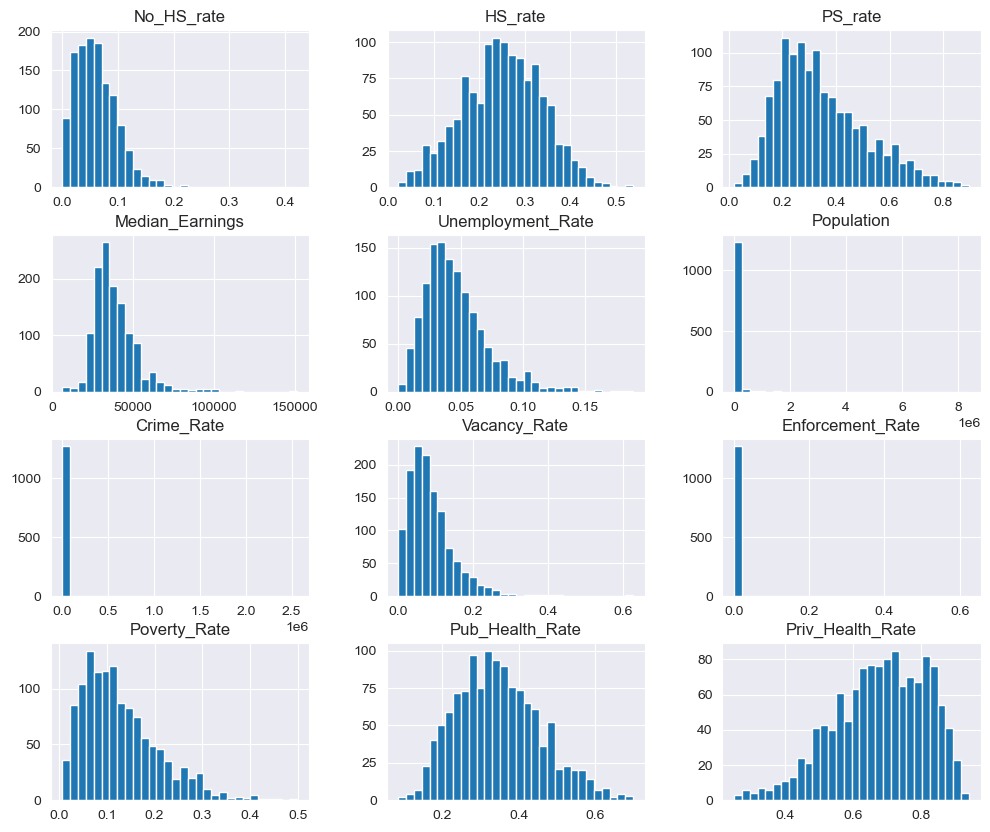

In [193]:
eda_df.hist(figsize = (12,10), bins=30)

In [108]:
eda_df.describe()

,No_HS_rate,HS_rate,PS_rate,Median_Earnings,Unemployment_Rate,Population,Crime_Rate,Vacancy_Rate,Enforcement_Rate,Poverty_Rate,Pub_Health_Rate,Priv_Health_Rate
count,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1.272000e+03,1.272000e+03,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000
mean,0.061919,0.249992,0.346663,38343.763365,0.046505,7.464680e+04,4.535769e+03,0.085991,0.002855,0.128045,0.346394,0.678922
std,0.040067,0.087926,0.164949,13751.390139,0.026428,2.925915e+05,7.179549e+04,0.061609,0.017518,0.079637,0.110011,0.135936
min,0.000000,0.022588,0.020342,6371.000000,0.000000,8.000000e+00,0.000000e+00,0.000000,0.000362,0.006832,0.084300,0.251533
25%,0.031794,0.189837,0.221455,30127.000000,0.028003,2.011675e+04,1.375597e+03,0.044458,0.001626,0.068115,0.265723,0.588902
50%,0.056258,0.249380,0.314911,35687.000000,0.041380,3.440150e+04,2.266018e+03,0.073081,0.002117,0.111868,0.339125,0.691119
75%,0.084350,0.313962,0.447622,44421.750000,0.058376,6.691400e+04,3.374256e+03,0.112206,0.002709,0.170800,0.418018,0.790610
max,0.422225,0.537981,0.896341,151581.000000,0.188542,8.379043e+06,2.562500e+06,0.627728,0.625000,0.499475,0.699280,0.939977


In [188]:
# from the table above there are extreme outliers in population and crime rate impacting their standard deviations
# so i opt for iqr to remove outliers rather than z-scores
outliers = dict()
for col in eda_df.columns:
    q1 = eda_df[col].quantile(0.25)
    q3 = eda_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    out_val = eda_df[col].loc[(eda_df[col] < lower_bound) | (eda_df[col] > upper_bound)]
    outliers.update(out_val.to_dict())

[11,
 68,
 78,
 84,
 92,
 98,
 105,
 110,
 150,
 165,
 180,
 232,
 246,
 251,
 356,
 418,
 844,
 853,
 869,
 882,
 1085,
 1089,
 1104,
 1137,
 578,
 1036,
 171,
 176,
 206,
 287,
 311,
 554,
 666,
 667,
 680,
 687,
 700,
 863,
 939,
 1189,
 80,
 83,
 91,
 93,
 112,
 119,
 131,
 133,
 145,
 154,
 174,
 181,
 191,
 195,
 212,
 213,
 221,
 236,
 242,
 245,
 250,
 253,
 260,
 264,
 276,
 330,
 400,
 434,
 436,
 506,
 532,
 583,
 648,
 662,
 685,
 692,
 701,
 714,
 783,
 827,
 858,
 903,
 914,
 1022,
 1176,
 1209,
 38,
 51,
 60,
 66,
 115,
 116,
 122,
 148,
 182,
 215,
 218,
 222,
 225,
 256,
 314,
 358,
 439,
 478,
 484,
 510,
 566,
 623,
 705,
 713,
 718,
 731,
 735,
 737,
 799,
 800,
 801,
 803,
 805,
 808,
 854,
 857,
 870,
 892,
 932,
 942,
 946,
 964,
 965,
 992,
 1039,
 1063,
 1114,
 1192,
 13,
 17,
 20,
 21,
 26,
 28,
 29,
 33,
 35,
 36,
 37,
 49,
 64,
 73,
 99,
 106,
 124,
 126,
 130,
 134,
 137,
 143,
 149,
 153,
 161,
 170,
 172,
 184,
 199,
 200,
 201,
 202,
 203,
 207,
 214,
 2

In [191]:
no_out_df = eda_df.drop(index = outliers.keys())
no_out_df

,No_HS_rate,HS_rate,PS_rate,Median_Earnings,Unemployment_Rate,Population,Crime_Rate,Vacancy_Rate,Enforcement_Rate,Poverty_Rate,Pub_Health_Rate,Priv_Health_Rate
0,0.110958,0.304470,0.316840,38209.0,0.014845,1913.0,575.013068,0.140883,0.002087,0.179552,0.351986,0.812879
1,0.017402,0.104354,0.666667,24009.0,0.036191,14201.0,2056.193226,0.086413,0.002225,0.261113,0.144547,0.885790
3,0.074216,0.346502,0.251752,32065.0,0.056615,1813.0,3474.903475,0.112543,0.002792,0.146167,0.379581,0.631620
4,0.112918,0.298505,0.269841,22546.0,0.051155,26385.0,447.223801,0.150321,0.003256,0.220114,0.386620,0.622856
5,0.015265,0.242606,0.370451,46427.0,0.017970,32806.0,4864.963726,0.023032,0.001510,0.029348,0.279521,0.801635
...,...,...,...,...,...,...,...,...,...,...,...,...
1266,0.044562,0.304977,0.278111,35929.0,0.022454,31638.0,1833.238511,0.002299,0.002213,0.051312,0.309767,0.792847
1267,0.047802,0.341818,0.218440,34240.0,0.021244,57752.0,3199.889181,0.105067,0.002493,0.114556,0.305023,0.683957
1268,0.032537,0.274381,0.310111,36692.0,0.022711,64501.0,3457.310739,0.058396,0.001953,0.099151,0.299144,0.783535
1269,0.045105,0.372053,0.138023,42644.0,0.011316,31960.0,2099.499374,0.116574,0.002503,0.093146,0.205234,0.786750


array([[<Axes: title={'center': 'No_HS_rate'}>,
        <Axes: title={'center': 'HS_rate'}>,
        <Axes: title={'center': 'PS_rate'}>],
       [<Axes: title={'center': 'Median_Earnings'}>,
        <Axes: title={'center': 'Unemployment_Rate'}>,
        <Axes: title={'center': 'Population'}>],
       [<Axes: title={'center': 'Crime_Rate'}>,
        <Axes: title={'center': 'Vacancy_Rate'}>,
        <Axes: title={'center': 'Enforcement_Rate'}>],
       [<Axes: title={'center': 'Poverty_Rate'}>,
        <Axes: title={'center': 'Pub_Health_Rate'}>,
        <Axes: title={'center': 'Priv_Health_Rate'}>]], dtype=object)

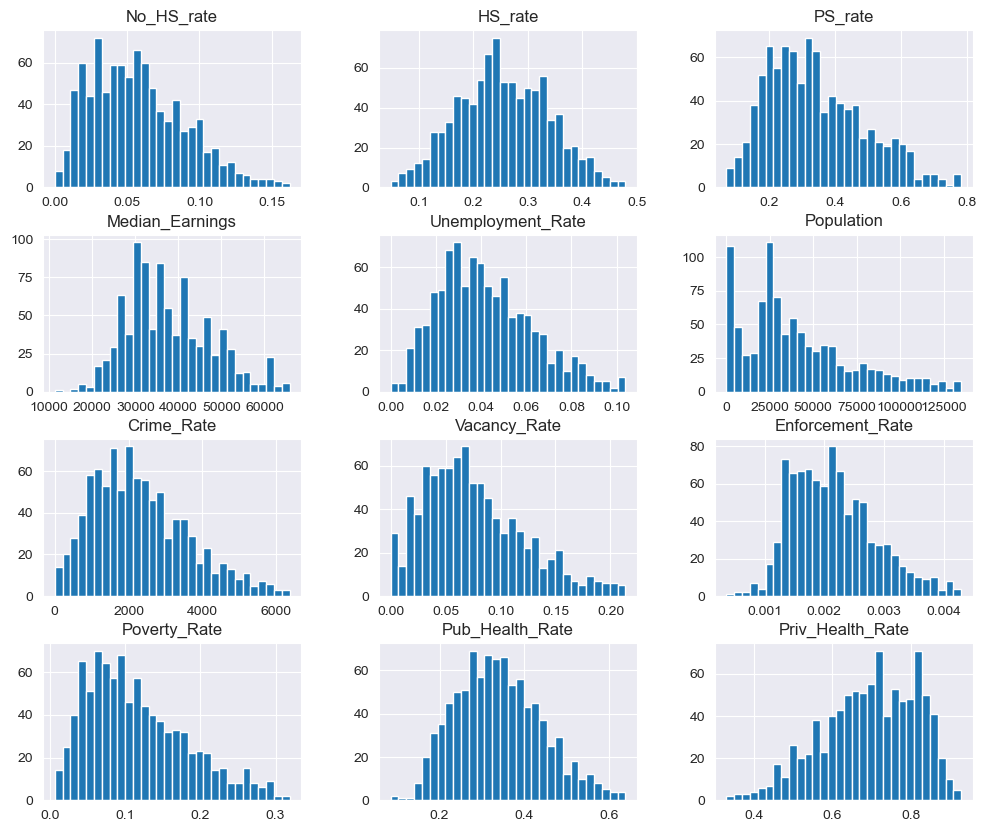

In [192]:
no_out_df.hist(figsize = (12,10), bins=30)

From the graphs above, There appears to be an issue with outliers in enforcement rate and population as a result to the difference in scale so a z-score threshold of 3.5 is not significant enough

<Axes: >

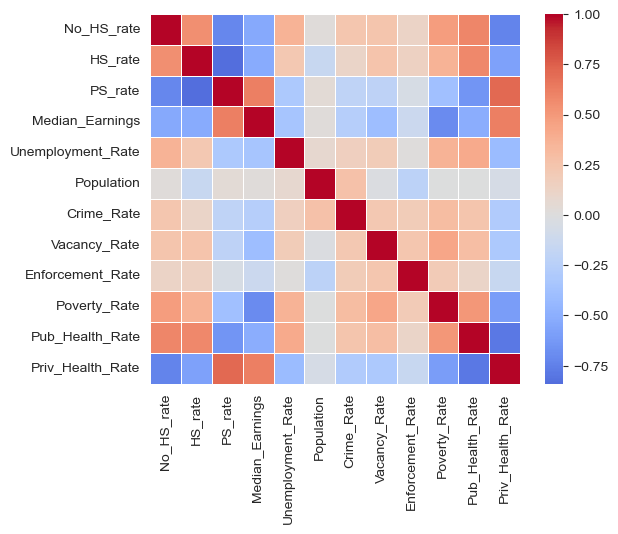

In [194]:
# creating a heatmap to visualize any highly collinear variables 
corr = no_out_df.corr()
sns.heatmap(corr, center=0, cmap= 'coolwarm', square=True, linewidths=.5)

In [196]:
# Checking the correlation between target and predictor variables
corr["Crime_Rate"].sort_values(ascending=False)

Crime_Rate           1.000000
Poverty_Rate         0.298930
Population           0.268641
Pub_Health_Rate      0.250682
No_HS_rate           0.234183
Vacancy_Rate         0.222959
Enforcement_Rate     0.190986
Unemployment_Rate    0.161132
HS_rate              0.112270
PS_rate             -0.203675
Median_Earnings     -0.262018
Priv_Health_Rate    -0.292690
Name: Crime_Rate, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


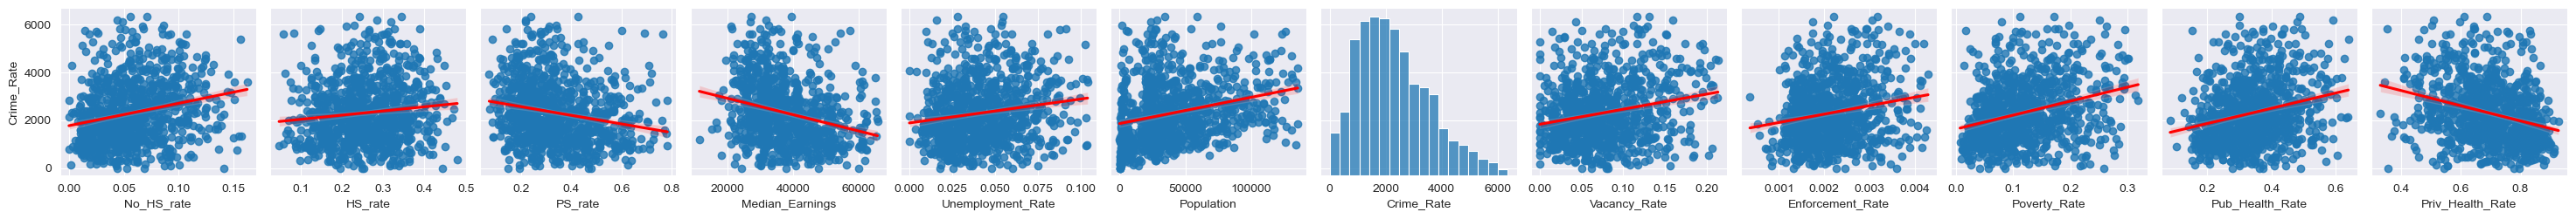

In [197]:
sns.pairplot(no_out_df, y_vars=["Crime_Rate"], kind="reg", plot_kws={'line_kws':{'color':'red'}})

From the pairplot, we can see that the variables are not suitable for linear regression, so I will build a random forest regression first, and compare the results with the gradient boosted version

# Random forest regression

In [198]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [199]:
y= no_out_df["Crime_Rate"]
x= no_out_df.drop("Crime_Rate", axis = 1)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2004)
rf = RandomForestRegressor(n_estimators=100, random_state=2004)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=2004)

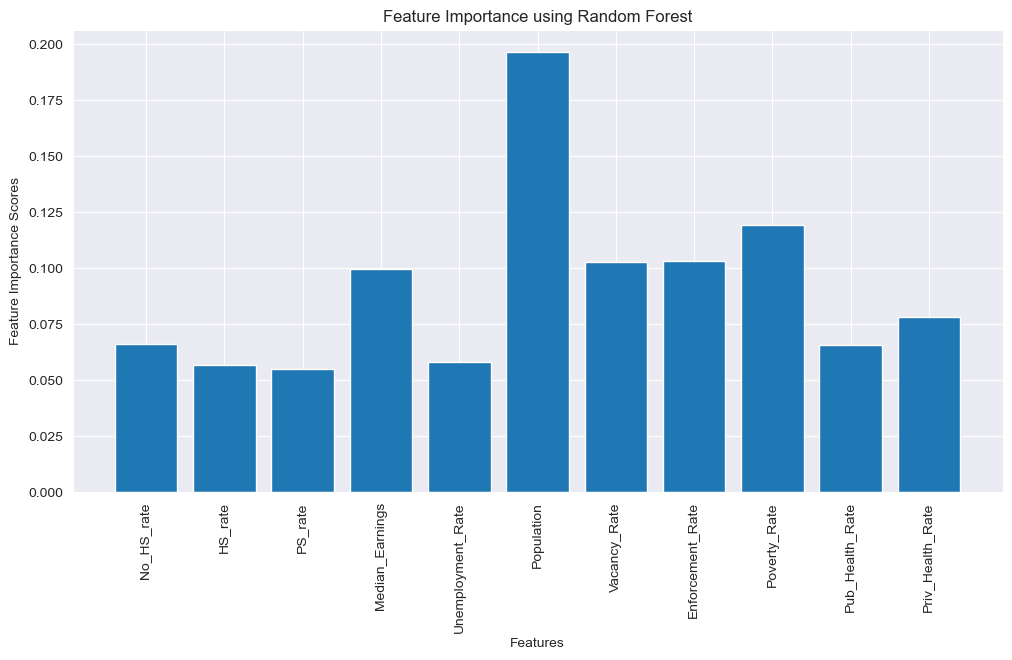

In [201]:
# a visualization for most important features in our regression
ft_list = rf.feature_importances_
plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), ft_list)
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.ylabel('Feature Importance Scores')
plt.xlabel('Features')
plt.title('Feature Importance using Random Forest')
plt.show()

In [202]:
# some hyperparameters for tuning
cv_params = {'max_depth': [15,50,75,100,150],
             'max_features': [1,3,5,10],
             'n_estimators': [75, 100, 125, 150],
             }
scoring = {'neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error'}

rf_cv = GridSearchCV(estimator=rf, param_grid=cv_params, scoring='neg_mean_absolute_error', cv=5)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2004),
             param_grid={'max_depth': [15, 50, 75, 100, 150],
                         'max_features': [1, 3, 5, 10],
                         'n_estimators': [75, 100, 125, 150]},
             scoring='neg_mean_absolute_error')

In [203]:
rf_cv.best_estimator_

RandomForestRegressor(max_depth=50, max_features=10, n_estimators=75,
                      random_state=2004)

In [204]:
predictions = rf_cv.predict(X_test)

In [205]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

In [206]:
# scoring metrics
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
explained_var = explained_variance_score(y_test, predictions)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R2 Score:", r2)
print("Explained Variance:", explained_var)

Mean Absolute Error: 803.1375131644364
Mean Squared Error: 1060445.011479204
Root Mean Squared Error: 1029.7791080999866
R2 Score: 0.2987128618281931
Explained Variance: 0.29872705196915283


The R2 score is very low which is to be expected as none of the variables demonstrated very high correlation with the target variable

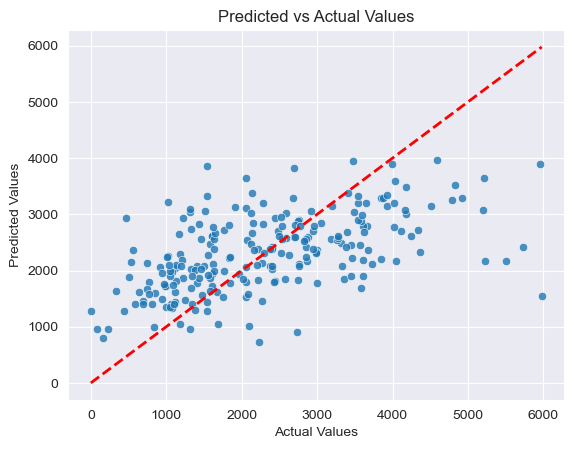

In [207]:
# visualizing the errors made by model
sns.scatterplot(x=y_test, y=predictions, alpha=0.8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


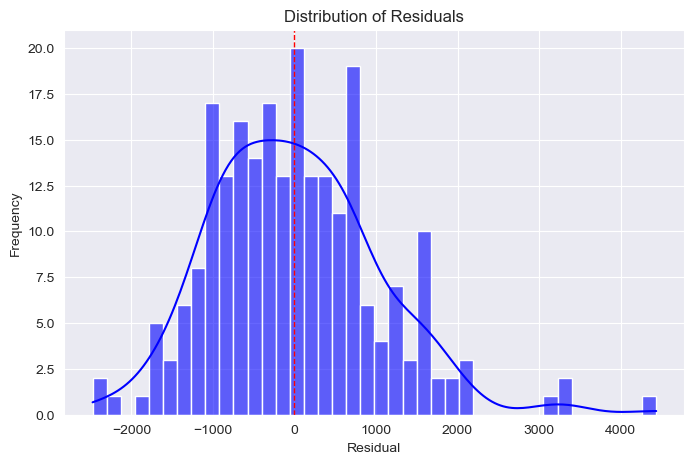

In [208]:
# Distribution of the errors made
residuals = y_test - predictions
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True, color='blue', alpha=0.6)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

The random forest model performs very poorly due to the low correlation as seen from the models above. The errors are common and most within 1000 of the true crime rate, which as seen from the distribution below

Text(0, 0.5, 'Frequency')

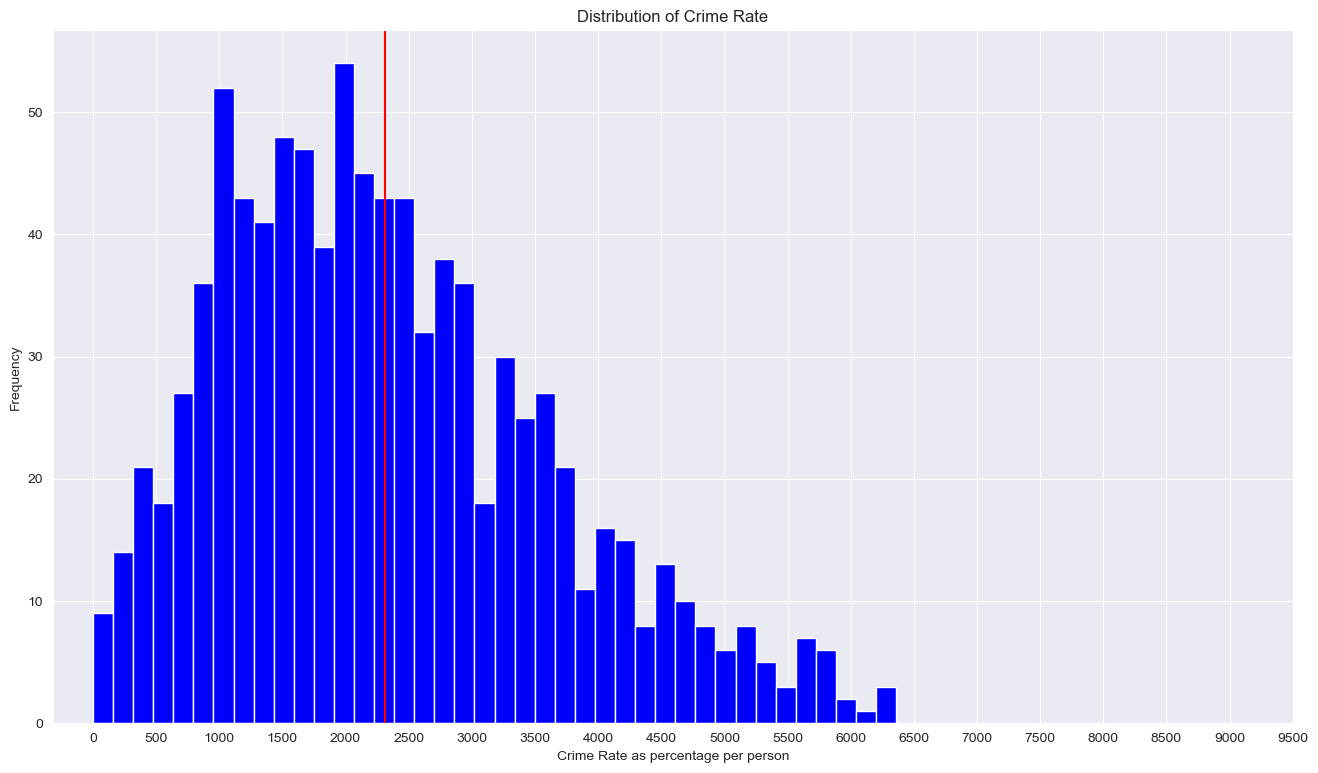

In [209]:
plt.figure(figsize=(16, 9))
no_out_df["Crime_Rate"].plot(kind='hist', bins=40, color='blue')
plt.axvline(no_out_df["Crime_Rate"].mean(), color='red')
plt.title("Distribution of Crime Rate")
plt.xlabel("Crime Rate as percentage per person")
plt.xticks(range(0,10000,500))
plt.ylabel("Frequency")

# Gradient boosted random forest

In [ ]:
from xgboost import XGBRegressor, plot_importance, plot_tree

In [212]:
xgb_model = XGBRegressor(random_state=2004)
# parameters to tune
xgb_params = {'max_depth': [15,50,75,125], 
             'min_child_weight': [1,5,10,15],
             'learning_rate': [0.01, 0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]}
xgb_scoring = {'neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error'}
xgb_cv = GridSearchCV(xgb_model, xgb_params, scoring=xgb_scoring, cv=5, refit="r2")

In [213]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=2004, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [15, 50, 75, 125],
                         'min_child_weight': [1, 5, 10, 15],
                         'n_estimators': [75, 100, 125]},
             refit='r2',
             scoring={'neg_mean_absolute_error', 'neg_root_mean_squared_error',
                      'r2'})

In [215]:
model = xgb_cv.best_estimator_

Mean Absolute Error: 831.1539198410325
Mean Squared Error: 1109450.6868151892
Root Mean Squared Error: 1053.3046505238592
R2 Score: 0.2663047223786884
Explained Variance: 0.2685785662050528


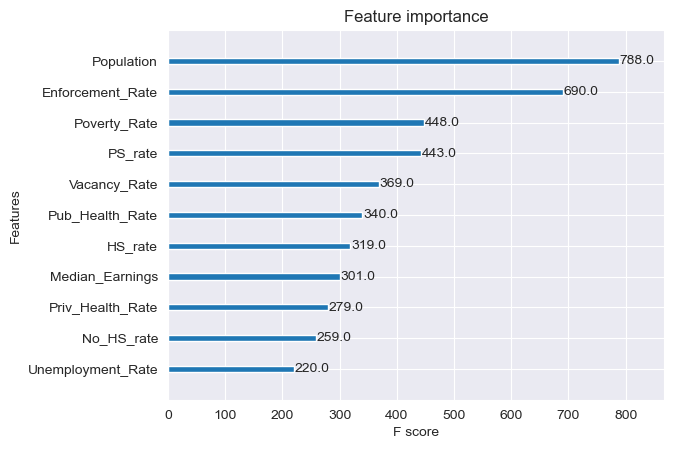

In [217]:
# Predict on test data
xgb_preds = model.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_preds)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)
xgb_explained_var = explained_variance_score(y_test, xgb_preds)
print("Mean Absolute Error:", xgb_mae)
print("Mean Squared Error:", xgb_mse)
print("Root Mean Squared Error:", xgb_rmse)
print("R2 Score:", xgb_r2)
print("Explained Variance:", xgb_explained_var)

# this is cool it breaks down to most important features for estimation
plot_importance(xgb_cv.best_estimator_);